### Historical Shape Indicator (HSI),  ETL for Trade Data Generation

In [1]:
import pandas as pd
from pandas import DatetimeIndex
import datetime 
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import scipy
from scipy import stats as scs
import statsmodels
from statsmodels import stats
from statsmodels.stats import weightstats
from statsmodels.stats.power import TTestIndPower
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import seaborn as sb
sb.set()
from alpha_vantage.timeseries import TimeSeries
from datetime import datetime, timedelta
np.set_printoptions(precision=2)
%matplotlib inline

#### Raw Data

In [2]:
def get_raw(sym='V'):
    '''
    download data and return data dictionary
    '''
    # download historical prices
    ts = TimeSeries(key='enter your access key')
    # Get json object with the intraday data and another with  the call's metadata
    data, meta_data = ts.get_daily_adjusted(sym, outputsize='full')
    return data

#### Format Raw Data

In [3]:
def format_raw(raw_dict):
    '''
    import raw dictionary
    format column names and sort date ascending
    return dataframe
    '''
    # reformat
    data = raw_dict.copy()
    df_raw = pd.DataFrame.from_dict(data).T
    df_raw.reset_index(level=0, inplace=True)
    df_raw = df_raw.rename(index=str, columns={'index':'date',
                                               '1. open': 'open', 
                                               '2. high': 'high',
                                               '3. low': 'low',
                                               '4. close':'close',
                                               '5. adjusted close':'adj_close',
                                               '6. volume':'volume',
                                               '7. dividend amount':'dividend',
                                               '8. split coefficient':'split',
                                              })
    df_raw = df_raw.sort_values(by='date', ascending=True)
    df_raw = df_raw.reset_index(drop=True)
    df_raw.date = pd.to_datetime(df_raw.date)
    
    return df_raw

In [4]:
def scale_adjusted(df_raw):
    '''
    import raw dataframe
    scale open,high,low, close to adjusted close
    return updated dataframe
    '''
    df = df_raw.copy()
    df_scale = pd.DataFrame()
    close = df.close.to_numpy().astype(float)
    adj = df.adj_close.to_numpy().astype(float)
    scale = adj / close
    df_scale['date'] = df['date'].copy()
    df_scale['open']=df.open.to_numpy().astype(float)*scale
    df_scale['high']=df.high.to_numpy().astype(float)*scale
    df_scale['low']=df.low.to_numpy().astype(float)*scale
    df_scale['close']=df.close.to_numpy().astype(float)*scale
    
    return df_scale

#### Preprocess Data

In [5]:
def compute_log_returns(prices):
    '''
    compute log returns
    '''
    return np.log(prices) - np.log(prices.shift(1))

In [6]:
def shift_returns(returns, shift_n):
    '''
    compute shift returns for trade assessment
    '''
    return returns.shift(shift_n)

In [7]:
def compute_proj(prices, lookahead_days):
    '''
    compute projected future lookahead returns
    lookahead_days is the number of days ahead we want to predict
    '''
    return (prices.shift(-lookahead_days) - prices)/prices

In [8]:
def compute_day_shape(prices, sigmas, dayspan):
    '''
    compute one day shape
    '''
    abs_deltas = (prices) - (prices.shift(dayspan))
    s_ratios = abs_deltas / sigmas
    ups = 3*(s_ratios>1)
    downs = 1*(s_ratios<-1)
    neuts = 2*((s_ratios>=-1)&(s_ratios<=1))      
    return (ups+downs+neuts)

In [9]:
def compute_shape(dayshape, dayspan):
    '''
    compute 5 day shape ordinals
    '''
    ago5s = 10000*(dayshape.shift(4*dayspan))
    ago4s = 1000*(dayshape.shift(3*dayspan))
    ago3s = 100*(dayshape.shift(2*dayspan))
    ago2s = 10*(dayshape.shift(1*dayspan))
    return (ago5s+ago4s+ago3s+ago2s+dayshape)

In [10]:
def preprocess(df):
    '''
    compute statistics 
    add return parameters
    add lookahead projections of 7 days
    use day shape spans of 1, 3 and 5 days
    build shape ordinals
    '''
    df_for = df.copy()
    
    # raw data overlaps
    shifts = [['o1','h1','l1','c1'],
              ['o2','h2','l2','c2'],
              ['o3','h3','l3','c3'],
              ['o4','h4','l4','c4'],
             ]
    # format df to calculate price estimates and standard deviations
    for j, shift in zip(range(1,6),shifts):
        df_for[shift[0]] = df_for.open.shift(-j)
        df_for[shift[1]] = df_for.high.shift(-j)
        df_for[shift[2]] = df_for.low.shift(-j)
        df_for[shift[3]] = df_for.close.shift(-j)

    # define price estimate columns for 1,3,5 day spans
    p1_col = df_for.loc[:,"open":"close"].astype(float)
    p3_col = df_for.loc[:,"open":"c2"].astype(float)
    p5_col = df_for.loc[:,"open":"c4"].astype(float)  
    p_cols = [p1_col, p3_col, p5_col]

    # compute price estimates and standard deviations for spans
    stats = [['pe1','sd1'],['pe3','sd3'],['pe5','sd5']]
    for stat, p_col in zip(stats, p_cols):
        df_for[stat[0]] = p_col.mean(axis=1)
        df_for[stat[1]] = p_col.std(axis=1)

    # keep date but leave raw data behind
    df_prep = df_for[['date','pe1','sd1','pe3','sd3','pe5','sd5']].copy()
    
    # add daily returns to df based on 1 day price estimates
    daily_returns = compute_log_returns(df_prep['pe1'])
    df_prep['log_ret'] = daily_returns
    
    # compute shift returns
    shift_1dlog = shift_returns(df_prep['log_ret'],-1)
    df_prep['shift_ret'] = shift_1dlog
    
    # add projections to df
    lookahead_days = 7
    aheads = compute_proj(df_prep['pe1'], lookahead_days)
    df_prep['proj'] = aheads
    
    # add day shapes to df
    dayshapes = ['ds1','ds3','ds5']
    dayspans = [1,3,5]
    for shape, stat, span in zip(dayshapes, stats, dayspans):
        df_prep[shape] = compute_day_shape(df_prep[stat[0]], df_prep[stat[1]], span)
        
    # add shapes to df
    shapes = ['shp1','shp3','shp5']
    for shape, dayshape, span in zip(shapes, dayshapes, dayspans):
        df_prep[shape] = compute_shape(df_prep[dayshape], span)

    #trim the head then format
    df_trim = df_prep[25:].copy()
    df_trim[['shp1','shp3','shp5']] = df_trim[['shp1','shp3','shp5']].astype(int)
    
    return df_trim  

In [11]:
def test_train_split(df_mkt, test_year):
    '''
    split preprocessed data into train and test dataframes
    train data comes from years prior to test year
    data in years beyond the test year is not used
    '''
    df = df_mkt.copy()
    years = df.date.map(lambda x: x.strftime('%Y')).astype(int)
    
    #train = years < test_year for 3 years behind
    train = ((test_year-3 < years) & (years < test_year))
    test = np.isin(years, test_year)

    df_train = df[train].copy()
    df_test = df[test].copy()
    
    return df_train, df_test

#### Shape Ranks

In [12]:
def compute_shaperank(df_train, shapename):
    '''
    enter preprocessed train data and shapename
    return HSI dataframe for that shapename
    '''
    shapes = df_train[shapename]
    projs = df_train['proj']
    
    s_list = list(set(shapes))
    p_avgs = []
    p_stds = []
    for shape in s_list:
        p_avgs.append((projs*(shapes==shape)).mean())
        p_stds.append((projs*(shapes==shape)).std())
    
    # initiate dataframe build
    df_shape = pd.DataFrame()
    df_shape['shape'] = s_list
    df_shape['p_avg'] = p_avgs
    df_shape['p_std'] = p_stds
    
    # shape ratio as a mini sharpe
    df_shape['p_srs'] = df_shape['p_avg']/df_shape['p_std']
    df_shape = df_shape.sort_values(by=['p_srs'])
    df_shape = df_shape.reset_index(drop=True)
    
    # normalize shape ratios into indicator
    short_range = df_shape['p_srs'].max() - df_shape['p_srs'].min() 
    short_min = df_shape['p_srs'].min()
    df_shape['HSI'] = (df_shape['p_srs'] - short_min)/short_range
    
    return df_shape     

In [13]:
def build_hsi(df_train):
    df1 = compute_shaperank(df_train, 'shp1')
    df3 = compute_shaperank(df_train, 'shp3')
    df5 = compute_shaperank(df_train, 'shp5')
    df_hsi = pd.concat({'shp1':df1, 'shp3':df3, 'shp5':df5}, axis=1)
    return df_hsi

In [14]:
def assign_hsi(df, df_shape):
    '''
    for daily market data
    lookup the HSI figures given shape ordinals
    return updated dataframe with daily HSI assignment
    '''
    df_mkt = df.copy()
    
    # HSI lookups
    shapenames = ['shp1','shp3','shp5']
    hsi_names = ['hsi1','hsi3','hsi5']
    
    for sname, hsi_name in zip(shapenames, hsi_names):
        lookups = []
        s_list = df_shape[sname]['shape'].tolist()
        for i,nrows in df_mkt.iterrows():
            shp = nrows[sname]
            # assign last known(or 0.5) for unknown shapes
            if shp in s_list:
                lookups.append(np.asscalar(df_shape[sname]\
                    [df_shape[sname]['shape']==shp]['HSI'].values))
            else:
                try:
                    lookups.append(lookups[-1])
                except:
                    lookups.append(0.5)
        df_mkt[hsi_name] = lookups
        
    # compile three into the average of the two closest
    nearest_two = []
    for i,nrows in df_mkt.iterrows():
        v1 = nrows['hsi1']
        v2 = nrows['hsi3']
        v3 = nrows['hsi5']
        diffs = np.abs([v1-v2, v2-v3, v1-v3])
        sums = [v1+v2, v2+v3, v1+v3]
        nearest_two.append(np.max((diffs==np.amin(diffs))*sums)/2)
        
    df_mkt['HSC'] = nearest_two

    return df_mkt 

#### Trade Rules

In [15]:
def compute_trades(indicator, highT, lowT):
    '''
    compare HSC to thresholds
    return binaries of in/out days
    '''
    trades = []
    inout = 0
    for ind in indicator:
        # from out to enter
        if inout == 0:
            if ind > highT:
                trades.append(1)
                inout = 1
            else:
                trades.append(0)
        # from in to exit
        else:
            if ind < lowT:
                trades.append(0)
                inout = 0
            else:
                trades.append(1)
    return trades

In [16]:
def opt_tresh(seedLow, seedHigh, step_range, df):
    '''
    successive approximation applied to optimizing thresholds
    '''
    df_mkt = df.copy()
    bestL = 0
    bestH = 0
    bestR = 0
    for i in range(20):
        t_low = seedLow + step_range*i/20

        for j in range(20):
            t_high = seedHigh + step_range*j/20

            trade = compute_trades(df_mkt['HSC'], t_high, t_low)
            returns = df_mkt['shift_ret']*trade
            expret = (np.exp(returns[1:].T.sum())-1)*100

            if expret > bestR:
                bestL = t_low
                bestH = t_high
                bestR = expret
                
    return bestL, bestH

In [17]:
def thresholds(df_train):
    '''
    determine trade rule thresholds
    '''
    # trim leader NaN's
    df = df_train.iloc[:-7].copy()
    
    low = 0.25
    high = 0.75
    res = 0
    r_values = [0.5,0.25,0.125]
    for r in r_values:
        low, high = opt_tresh((low-(r/2)),(high-(r/2)),r,df)
    
    return low, high

In [18]:
def find_trade_masks(trade_array):
    '''
    Import optimal trades
    Export buy and sell day masks for sub-optimal (late) trades
    '''
    trades = trade_array.copy()
    num_days = len(trades)
    # range limit days after threshold cross
    late = 5
    
    # trade changes as threshold crossings
    difference = np.diff(trades)
    
    # optimal threshold day indices
    buys = np.where(difference==1)
    sells = np.where(difference==-1)
    
    # optimals + late day indices using heavy numpy
    late_days = np.arange(late)
    buy_index_array = np.unique(np.sort(np.add(np.tile(
        late_days,[len(buys[0]),1]).T,buys[0]).flatten()))
    sell_index_array = np.unique(np.sort(np.add(np.tile(
        late_days,[len(sells[0]),1]).T,sells[0]).flatten()))
    
    # truncate those out of range
    buy_index_array = buy_index_array[buy_index_array<num_days]
    sell_index_array = sell_index_array[sell_index_array<num_days]
    
    # build mask arrays from indices
    buy_mask_array = np.zeros(num_days, dtype=int)
    buy_mask_array[buy_index_array] = 1
    sell_mask_array = np.zeros(num_days, dtype=int)
    sell_mask_array[sell_index_array] = 1
    
    return buy_mask_array, sell_mask_array

In [19]:
def find_trade_idxs(b_mask, s_mask):
    '''
    import buy and sell masks
    return list of buy/sell index tuples 
    '''
    find = []
    buys = b_mask.copy()
    sells = s_mask.copy()
    s_num = len(sells)
    # itterate through buys
    for i, buy in enumerate(buys):
        if buy ==1:
            # manage buys at end without sells
            try:
                s_index = np.argmax(sells[i+1:])+i+1
            except:
                s_index = 0
        else:
            s_index = 0
        if s_index != 0:
            flag = 0
            c = 0
            # permutate out sells for each buy
            while flag == 0:
                find.append((i, s_index))
                if s_index+1 < s_num:
                    if sells[s_index+1]==1:
                        s_index = s_index + 1
                    else:
                        flag = 1
                else:
                    flag = 1
    return find  

In [20]:
def assign_actions(df_test, lowT, highT):
    '''
    identify buy and sell day possibilities
    return actions dataframe for those possibilities
    '''
    df = df_test.copy()
    df_actions = pd.DataFrame()
    prices = df['pe1'].tolist()
    
    # get trade mask possibilities
    trades = df['trade'].to_numpy()
    buys, sells = find_trade_masks(trades)
    
    # mask where indicator above or below thresholds
    HSC = df['HSC'].to_numpy()
    b_ok = (HSC > highT)*1
    s_ok = (HSC < lowT)*1
    
    # get list of (buy,sell) trade tuples
    t_list = find_trade_idxs(buys*b_ok, sells*s_ok)
    
    # get trade returns
    trade_ret = []
    buy_day = []
    sell_day = []
    # iterate through trades
    for trade in t_list:
        buy,sell = trade
        log_ret = (np.log(prices[sell]) - np.log(prices[buy]))
        # record buys
        df_actions = df_actions.append(df.iloc[buy], ignore_index=True)
        trade_ret.append(log_ret)
        buy_day.append(1)
        sell_day.append(0)
        # record sells
        df_actions = df_actions.append(df.iloc[sell], ignore_index=True)
        trade_ret.append(log_ret)
        buy_day.append(0)
        sell_day.append(1)
    df_actions['t_ret'] = trade_ret
    df_actions['buyday'] = buy_day
    df_actions['sellday'] = sell_day
    df_actions['date'] = pd.to_datetime(df_actions['date'])
    
    return df_actions

In [21]:
def summarize(df_actions):
    '''
    import action dataframe
    slice by date and buy/sell days
    compute mean returns for buys and sells
    return summary dataframe
    '''
    df = df_actions.copy()
    dates = df.date.unique()
    mean_ret = []
    df_sum = pd.DataFrame()
    for date in dates:
        #buy days
        df_slice = df[(df['date']==date)&(df['buyday']==1.)]
        if len(df_slice)>0:
            df_sum = df_sum.append(df_slice.iloc[0])
            mean_ret.append(df_slice['t_ret'].mean())
        #sell days    
        df_slice = df[(df['date']==date)&(df['sellday']==1.)] 
        if len(df_slice)>0:
            df_sum = df_sum.append(df_slice.iloc[0])
            mean_ret.append(df_slice['t_ret'].mean())
            
    df_sum['mean_ret'] = mean_ret
    df_sum = df_sum.drop(['t_ret'], axis=1)
    df_sum = df_sum.dropna()
        
    return df_sum   

#### ETL Pipeline

In [22]:
def run_etl(ticker):
    '''
    run ETL pipeline
    '''
    print('Runnning ETL for '+ ticker)
    dict_raw = get_raw(ticker)
    
    print('formatting')
    df_for = format_raw(dict_raw)
    df_scale = scale_adjusted(df_for)
    
    print('preprocessing')
    df_pre = preprocess(df_scale)
    df_pre['symbol'] = ticker
    
    print('begin test itterations')
    years = [2014, 2015, 2016, 2017, 2018, 2019]
    df_trades = pd.DataFrame()
    
    for test_year in years:
        
        print('starting test year {}'.format(test_year))
        print('test-train split')
        df_train, df_test = test_train_split(df_pre[:-7], test_year)

        print('training shapes')
        df_shape = build_hsi(df_train)
        df_train = assign_hsi(df_train, df_shape)
        df_test = assign_hsi(df_test, df_shape)

        print('optimizing trade thresholds')
        lowT, highT = thresholds(df_train)
        
        print('computing trades')
        trades = compute_trades(df_test['HSC'].tolist(), highT, lowT)
        df_test['trade'] = trades
        
        print('building trade possibilities')
        df_act = assign_actions(df_test, lowT, highT)
        
        print('sumarizing trade days')
        df_sum = summarize(df_act)

        print('saving trades')
        df_trades = pd.concat([df_trades, df_sum],ignore_index=True)
        
    return df_trades, df_shape, lowT, highT

#### Run Trade Generator

In [23]:
# import candidates
df_stocks = pd.read_csv('cherries_102919.csv')
t_list = df_stocks.symbol.unique().tolist()

df_tradedata = pd.DataFrame()
ts_list = []
hi_list = []
low_list = []

# run etl
for ticker in t_list:
    try:
        df_trades, df_shape, lowT, highT = run_etl(ticker)
        df_trades['symbol'] = ticker
        df_tradedata = pd.concat([df_tradedata, df_trades],ignore_index=True)
        ts_list.append(ticker)
        hi_list.append(highT)
        low_list.append(lowT)
        # save shapes - make sure "hsi_data" folder is built beforehand
        df_shape.to_csv("hsi_data/{}_hsi.csv".format(ticker), index=False)
    except:
        pass
    
# save threshold and generated data
df_thrsh = pd.DataFrame({'ticker':ts_list,'lowT':low_list,'highT':hi_list})
df_thrsh.to_csv('hsi_thrsh_2d.csv',index=False)
df_tradedata.to_csv('trade_gen_5d.csv',index=False)

Runnning ETL for ENTG
formatting
preprocessing
begin test itterations
starting test year 2014
test-train split
training shapes
optimizing trade thresholds
computing trades
building trade possibilities
sumarizing trade days
saving trades
starting test year 2015
test-train split
training shapes
optimizing trade thresholds
computing trades
building trade possibilities
sumarizing trade days
saving trades
starting test year 2016
test-train split
training shapes
optimizing trade thresholds
computing trades
building trade possibilities
sumarizing trade days
saving trades
starting test year 2017
test-train split
training shapes
optimizing trade thresholds
computing trades
building trade possibilities
sumarizing trade days
saving trades
starting test year 2018
test-train split
training shapes
optimizing trade thresholds
computing trades
building trade possibilities
sumarizing trade days
saving trades
starting test year 2019
test-train split
training shapes
optimizing trade thresholds
computing 

optimizing trade thresholds
computing trades
building trade possibilities
sumarizing trade days
saving trades
starting test year 2016
test-train split
training shapes
optimizing trade thresholds
computing trades
building trade possibilities
sumarizing trade days
saving trades
starting test year 2017
test-train split
training shapes
optimizing trade thresholds
computing trades
building trade possibilities
sumarizing trade days
saving trades
starting test year 2018
test-train split
training shapes
optimizing trade thresholds
computing trades
building trade possibilities
sumarizing trade days
saving trades
starting test year 2019
test-train split
training shapes
optimizing trade thresholds
computing trades
building trade possibilities
sumarizing trade days
saving trades
Runnning ETL for SAIA
formatting
preprocessing
begin test itterations
starting test year 2014
test-train split
training shapes
optimizing trade thresholds
computing trades
building trade possibilities
sumarizing trade days

saving trades
starting test year 2016
test-train split
training shapes
optimizing trade thresholds
computing trades
building trade possibilities
sumarizing trade days
saving trades
starting test year 2017
test-train split
training shapes
optimizing trade thresholds
computing trades
building trade possibilities
sumarizing trade days
saving trades
starting test year 2018
test-train split
training shapes
optimizing trade thresholds
computing trades
building trade possibilities
sumarizing trade days
saving trades
starting test year 2019
test-train split
training shapes
optimizing trade thresholds
computing trades
building trade possibilities
sumarizing trade days
saving trades
Runnning ETL for FMC
formatting
preprocessing
begin test itterations
starting test year 2014
test-train split
training shapes
optimizing trade thresholds
computing trades
building trade possibilities
sumarizing trade days
saving trades
starting test year 2015
test-train split
training shapes
optimizing trade threshol

optimizing trade thresholds
computing trades
building trade possibilities
sumarizing trade days
saving trades
starting test year 2016
test-train split
training shapes
optimizing trade thresholds
computing trades
building trade possibilities
sumarizing trade days
saving trades
starting test year 2017
test-train split
training shapes
optimizing trade thresholds
computing trades
building trade possibilities
sumarizing trade days
saving trades
starting test year 2018
test-train split
training shapes
optimizing trade thresholds
computing trades
building trade possibilities
sumarizing trade days
saving trades
starting test year 2019
test-train split
training shapes
optimizing trade thresholds
computing trades
building trade possibilities
sumarizing trade days
saving trades
Runnning ETL for WST
formatting
preprocessing
begin test itterations
starting test year 2014
test-train split
training shapes
optimizing trade thresholds
computing trades
building trade possibilities
sumarizing trade days


sumarizing trade days
saving trades
starting test year 2016
test-train split
training shapes
optimizing trade thresholds
computing trades
building trade possibilities
sumarizing trade days
saving trades
starting test year 2017
test-train split
training shapes
optimizing trade thresholds
computing trades
building trade possibilities
sumarizing trade days
saving trades
starting test year 2018
test-train split
training shapes
optimizing trade thresholds
computing trades
building trade possibilities
sumarizing trade days
saving trades
starting test year 2019
test-train split
training shapes
optimizing trade thresholds
computing trades
building trade possibilities
sumarizing trade days
saving trades
Runnning ETL for NDAQ
formatting
preprocessing
begin test itterations
starting test year 2014
test-train split
training shapes
optimizing trade thresholds
computing trades
building trade possibilities
sumarizing trade days
saving trades
starting test year 2015
test-train split
training shapes
op

building trade possibilities
sumarizing trade days
saving trades
starting test year 2018
test-train split
training shapes
optimizing trade thresholds
computing trades
building trade possibilities
sumarizing trade days
saving trades
starting test year 2019
test-train split
training shapes
optimizing trade thresholds
computing trades
building trade possibilities
sumarizing trade days
saving trades
Runnning ETL for ADI
formatting
preprocessing
begin test itterations
starting test year 2014
test-train split
training shapes
optimizing trade thresholds
computing trades
building trade possibilities
sumarizing trade days
saving trades
starting test year 2015
test-train split
training shapes
optimizing trade thresholds
computing trades
building trade possibilities
sumarizing trade days
saving trades
starting test year 2016
test-train split
training shapes
optimizing trade thresholds
computing trades
building trade possibilities
sumarizing trade days
saving trades
starting test year 2017
test-tr

optimizing trade thresholds
computing trades
building trade possibilities
sumarizing trade days
saving trades
starting test year 2016
test-train split
training shapes
optimizing trade thresholds
computing trades
building trade possibilities
sumarizing trade days
saving trades
starting test year 2017
test-train split
training shapes
optimizing trade thresholds
computing trades
building trade possibilities
sumarizing trade days
saving trades
starting test year 2018
test-train split
training shapes
optimizing trade thresholds
computing trades
building trade possibilities
sumarizing trade days
saving trades
starting test year 2019
test-train split
training shapes
optimizing trade thresholds
computing trades
building trade possibilities
sumarizing trade days
saving trades


In [24]:
df_thrsh.head()

,highT,lowT,ticker
0,0.68125,0.28125,ENTG
1,0.74375,0.30000,BLD
2,0.72500,0.39375,JBSS
3,0.52500,0.38750,TMHC
4,0.50625,0.36875,FAF


In [25]:
len(df_thrsh)

84

In [26]:
len(df_tradedata)

38105

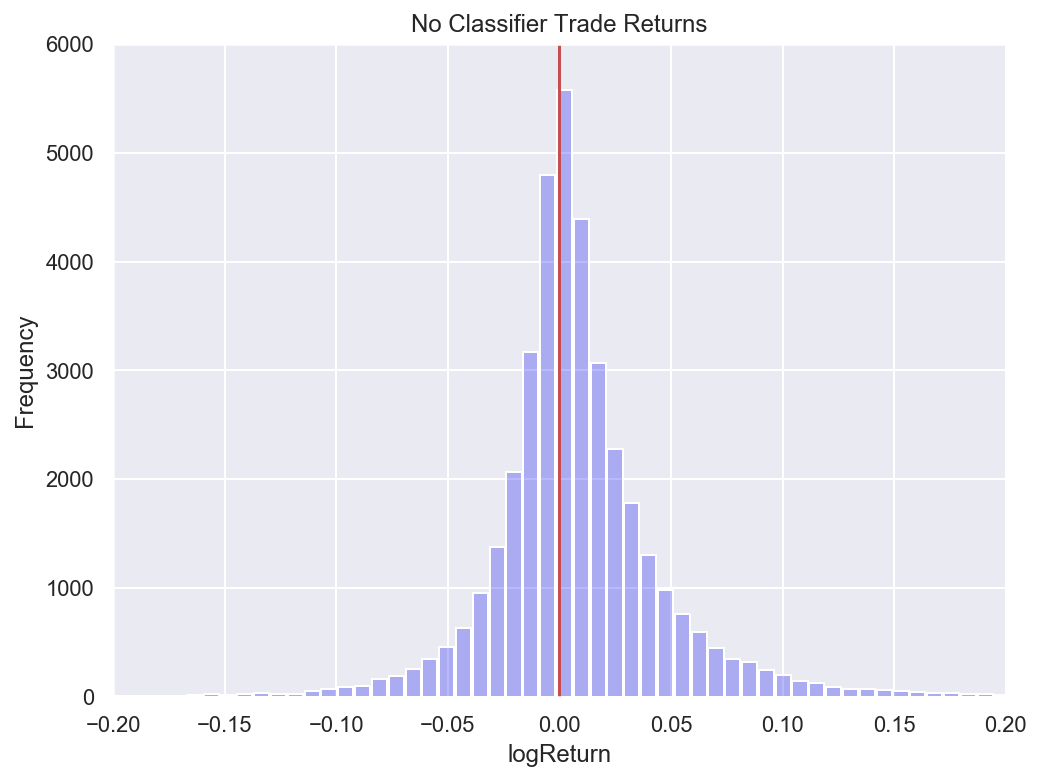

In [32]:
%config InlineBackend.figure_format = 'retina'

# plot no classifier trade returns
plt.figure(figsize=(8,6))
df_tradedata.mean_ret.plot.hist(grid=True, 
                bins=600, rwidth=0.9, color= (.1,.1,.95,.3))
plt.title('No Classifier Trade Returns')
plt.xlabel('logReturn')
plt.ylabel('Frequency')
plt.axvline(x=0, color='r')
plt.xlim(-0.2, 0.2)
plt.ylim(0,6000)
plt.xticks(np.arange(-0.2, 0.25, step=0.05));


In [33]:
len(df_tradedata[df_tradedata['mean_ret']>0])/len(df_tradedata[df_tradedata['mean_ret']<=0])

1.368682787343818

### Disclaimer: this notebook is intended for educational purposes only and not recommended for real trading.